### Problem statement 

Given daily and hourly breakdown of bike rental demand, we need to train a model that predicts the total count of demand for given conditions.<br/>
Input includes date, season, month, holiday indicator, weekday, workingday indicator, weather condition, temperature, feel-like temperature, humidity, windspeed, casual count, registered(member) count and total count <br/>
We need to predict 3 values - casual, registered and total count | Input for model prediction dosent include these 3 values<br/>

### Approach 
We can approach in 2 ways.
1. Time series approach (complex and training time consuming)
2. linear or tree based approach (comparitively simpler approach)

For demonstration, applying time-series on daily data and linear/tree model on hourly data




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
daily_data = pd.read_csv("day.csv")

In [3]:
daily_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [4]:
hour_data = pd.read_csv("hour.csv")

In [5]:
hour_data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


#### Rename columns

In [6]:
daily_data.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [7]:
# column renames
rename_dic = {
    'dteday':"date",
    'yr': "year",
    "mnth": "month",
    "weathersit": "weather",
    "temp": "temperature",
    "atemp": "feel_like_temp",
    "hum": "humidity",
    'cnt': "count"
}
daily_data.rename(rename_dic, axis=1, inplace=True)

In [8]:
hour_data.rename(rename_dic, axis=1, inplace=True)

#### Drop instant column

In [9]:
daily_data.drop(["instant"], axis=1, inplace=True)
hour_data.drop(["instant"], axis=1, inplace=True)

#### Null check

In [10]:
daily_data.isnull().sum()

date              0
season            0
year              0
month             0
holiday           0
weekday           0
workingday        0
weather           0
temperature       0
feel_like_temp    0
humidity          0
windspeed         0
casual            0
registered        0
count             0
dtype: int64

In [11]:
hour_data.isnull().sum()

date              0
season            0
year              0
month             0
hr                0
holiday           0
weekday           0
workingday        0
weather           0
temperature       0
feel_like_temp    0
humidity          0
windspeed         0
casual            0
registered        0
count             0
dtype: int64

* There are no null values in both data frames

#### Prepare data for EDA

In [12]:
daily_data2 = daily_data.copy()
hour_data2 = hour_data.copy()

In [13]:
daily_data2.columns

Index(['date', 'season', 'year', 'month', 'holiday', 'weekday', 'workingday',
       'weather', 'temperature', 'feel_like_temp', 'humidity', 'windspeed',
       'casual', 'registered', 'count'],
      dtype='object')

In [14]:
daily_data2["season"] = daily_data2["season"].map({1:"winter", 2:"spring", 3:"summer", 4:"fall"})

daily_data2["holiday"] = daily_data2["holiday"].map({0:"no", 1:"yes"})

daily_data2["workingday"] = daily_data2["workingday"].map({0:"no", 1:"yes"})

daily_data2["weather"] = daily_data2["weather"].map({1:"clear", 2:"cloudy", 3:"rain", 4:"thunderstrome"})

daily_data2['month'] = daily_data2['month'].map({i: month for i, month in enumerate(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                                                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], start=1)})

daily_data2['weekday'] = daily_data2['weekday'].map({0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'})


In [15]:
daily_data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            731 non-null    object 
 1   season          731 non-null    object 
 2   year            731 non-null    int64  
 3   month           731 non-null    object 
 4   holiday         731 non-null    object 
 5   weekday         731 non-null    object 
 6   workingday      731 non-null    object 
 7   weather         731 non-null    object 
 8   temperature     731 non-null    float64
 9   feel_like_temp  731 non-null    float64
 10  humidity        731 non-null    float64
 11  windspeed       731 non-null    float64
 12  casual          731 non-null    int64  
 13  registered      731 non-null    int64  
 14  count           731 non-null    int64  
dtypes: float64(4), int64(4), object(7)
memory usage: 85.8+ KB


In [16]:
daily_data2.head()

,date,season,year,month,holiday,weekday,workingday,weather,temperature,feel_like_temp,humidity,windspeed,casual,registered,count
0,2011-01-01,winter,0,Jan,no,Sat,no,cloudy,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2011-01-02,winter,0,Jan,no,Sun,no,cloudy,0.363478,0.353739,0.696087,0.248539,131,670,801
2,2011-01-03,winter,0,Jan,no,Mon,yes,clear,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,2011-01-04,winter,0,Jan,no,Tue,yes,clear,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,2011-01-05,winter,0,Jan,no,Wed,yes,clear,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [17]:
hour_data2["season"] = hour_data2["season"].map({1:"winter", 2:"spring", 3:"summer", 4:"fall"})

hour_data2["holiday"] = hour_data2["holiday"].map({0:"no", 1:"yes"})

hour_data2["workingday"] = hour_data2["workingday"].map({0:"no", 1:"yes"})

hour_data2["weather"] = hour_data2["weather"].map({1:"clear", 2:"cloudy", 3:"rain", 4:"thunderstrome"})

hour_data2['month'] = hour_data2['month'].map({i: month for i, month in enumerate(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                                                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], start=1)})

hour_data2['weekday'] = hour_data2['weekday'].map({0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'})


In [18]:

daily_data2.describe().T

,count,mean,std,min,25%,50%,75%,max
year,731.0,0.500684,0.500342,0.000000,0.000000,1.000000,1.000000,1.000000
temperature,731.0,0.495385,0.183051,0.059130,0.337083,0.498333,0.655417,0.861667
feel_like_temp,731.0,0.474354,0.162961,0.079070,0.337842,0.486733,0.608602,0.840896
humidity,731.0,0.627894,0.142429,0.000000,0.520000,0.626667,0.730209,0.972500
windspeed,731.0,0.190486,0.077498,0.022392,0.134950,0.180975,0.233214,0.507463
casual,731.0,848.176471,686.622488,2.000000,315.500000,713.000000,1096.000000,3410.000000
registered,731.0,3656.172367,1560.256377,20.000000,2497.000000,3662.000000,4776.500000,6946.000000
count,731.0,4504.348837,1937.211452,22.000000,3152.000000,4548.000000,5956.000000,8714.000000


In [19]:
daily_data2.describe(include="O").T

,count,unique,top,freq
date,731,731,2011-01-01,1
season,731,4,summer,188
month,731,12,Jan,62
holiday,731,2,no,710
weekday,731,7,Sat,105
workingday,731,2,yes,500
weather,731,3,clear,463


In [20]:
daily_data2[(daily_data2['casual'] + daily_data2['registered']) != daily_data2['count']]

,date,season,year,month,holiday,weekday,workingday,weather,temperature,feel_like_temp,humidity,windspeed,casual,registered,count


#### EDA

In [21]:
daily_data2.columns

Index(['date', 'season', 'year', 'month', 'holiday', 'weekday', 'workingday',
       'weather', 'temperature', 'feel_like_temp', 'humidity', 'windspeed',
       'casual', 'registered', 'count'],
      dtype='object')

In [22]:
# univariant cols 
# count - season, weather
# hist - temperature, feel_like_temp, humidity, windspeed
# box plot - temperature, feel_like_temp, humidity, windspeed, casual, registered, count

<Axes: xlabel='season', ylabel='count'>

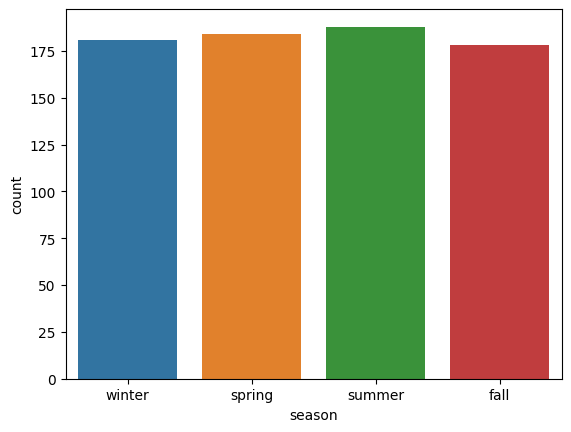

In [23]:
sns.countplot(x=daily_data2.season, hue=daily_data2.season)

<Axes: xlabel='weather', ylabel='count'>

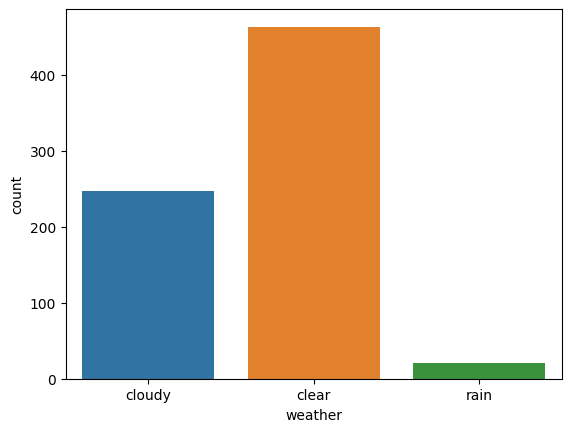

In [24]:
sns.countplot(x=daily_data2.weather, hue=daily_data2.weather)

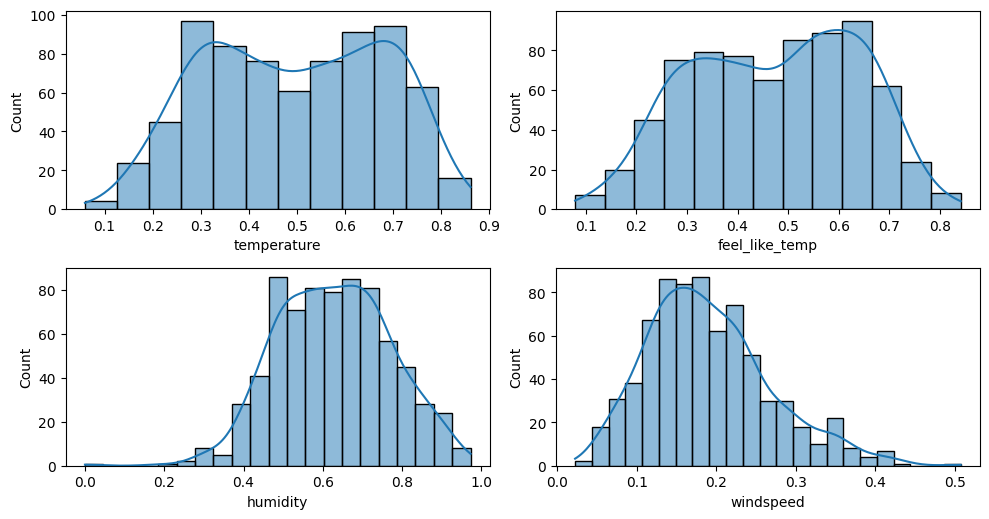

In [25]:
plt.figure(figsize=(10,10))
for i, col in enumerate(["temperature", "feel_like_temp", "humidity", "windspeed"]):
    ax = plt.subplot(4,2, i+1)
    sns.histplot(x=daily_data2[col], kde=True)
plt.tight_layout()
plt.show()

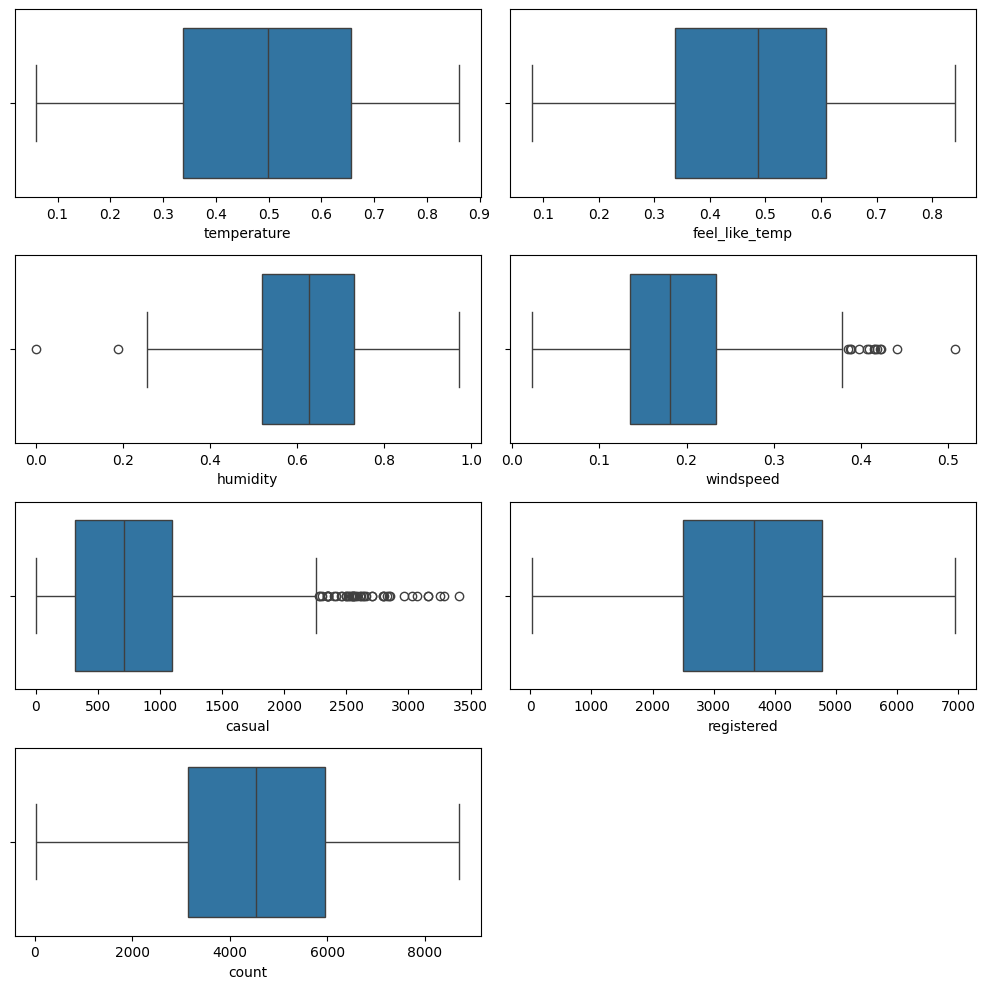

In [26]:
plt.figure(figsize=(10,10))
for i, col in enumerate(["temperature", "feel_like_temp", "humidity", "windspeed","casual", "registered", "count"]):
    ax = plt.subplot(4,2, i+1)
    sns.boxplot(x=daily_data2[col])
plt.tight_layout()
plt.show()

* Not handling Outliers since there are possibilities to have very low humidity and high windspeed samples
* There is high number of count considered as outlier for casual users, this might give us more insight. Not fixing the outliers

In [27]:
daily_data2.columns

Index(['date', 'season', 'year', 'month', 'holiday', 'weekday', 'workingday',
       'weather', 'temperature', 'feel_like_temp', 'humidity', 'windspeed',
       'casual', 'registered', 'count'],
      dtype='object')

In [28]:
# Bi-variant
# scatter plot with count - temperature, feel_like_temp, humidity, windspeed
# violine plot with count - season, month, holiday, weekday, workingday, weather

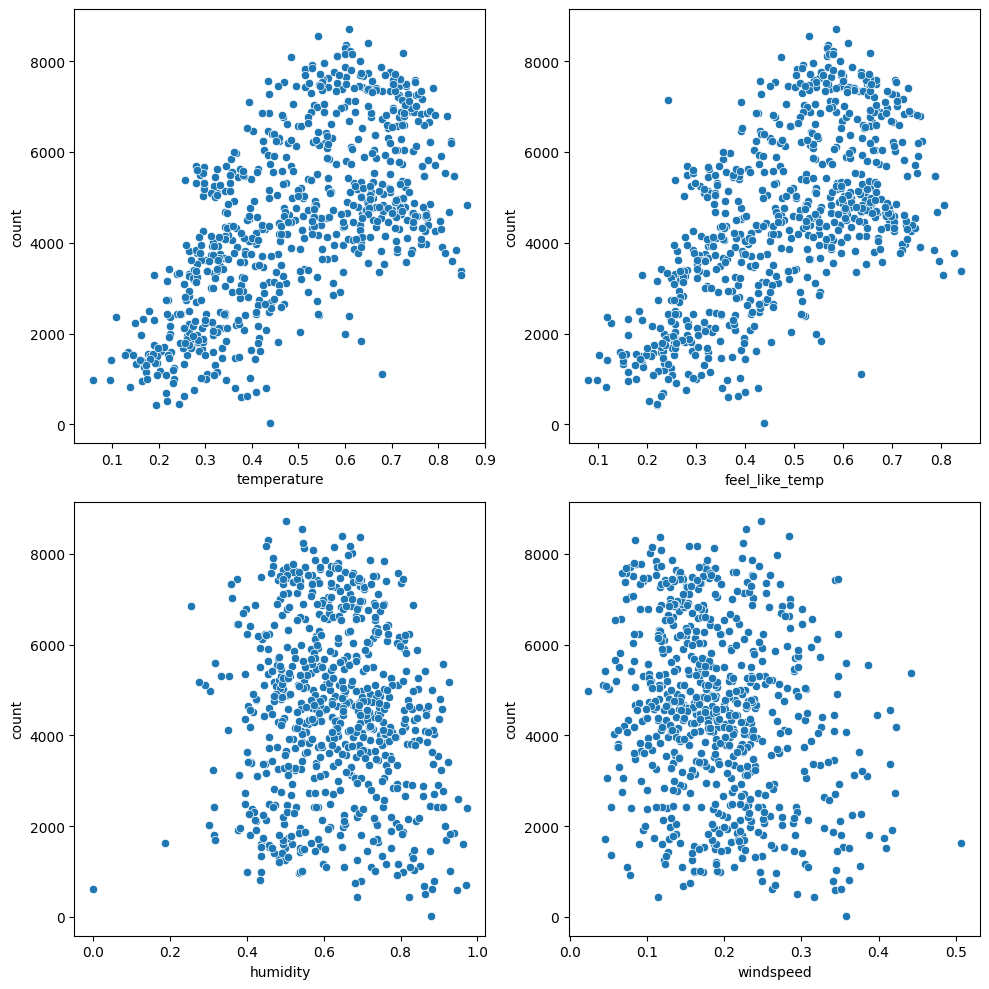

In [29]:
plt.figure(figsize=(10,10))
for i, col in enumerate(["temperature", "feel_like_temp", "humidity", "windspeed"]):
    plt.subplot(2,2,i+1)
    sns.scatterplot(x=daily_data2[col], y = daily_data2["count"])
plt.tight_layout()
plt.show()

* As the temperature increases, the number of rides also increases. High temperature is better condition for a ride.
* Feels-like temperature is similar to temperature.
* Similar to temperature, as humidity increases, no. of rides also increases
* As windspeed increases, the no.of rides decreases.

In [30]:
daily_data2.season.unique()

array(['winter', 'spring', 'summer', 'fall'], dtype=object)

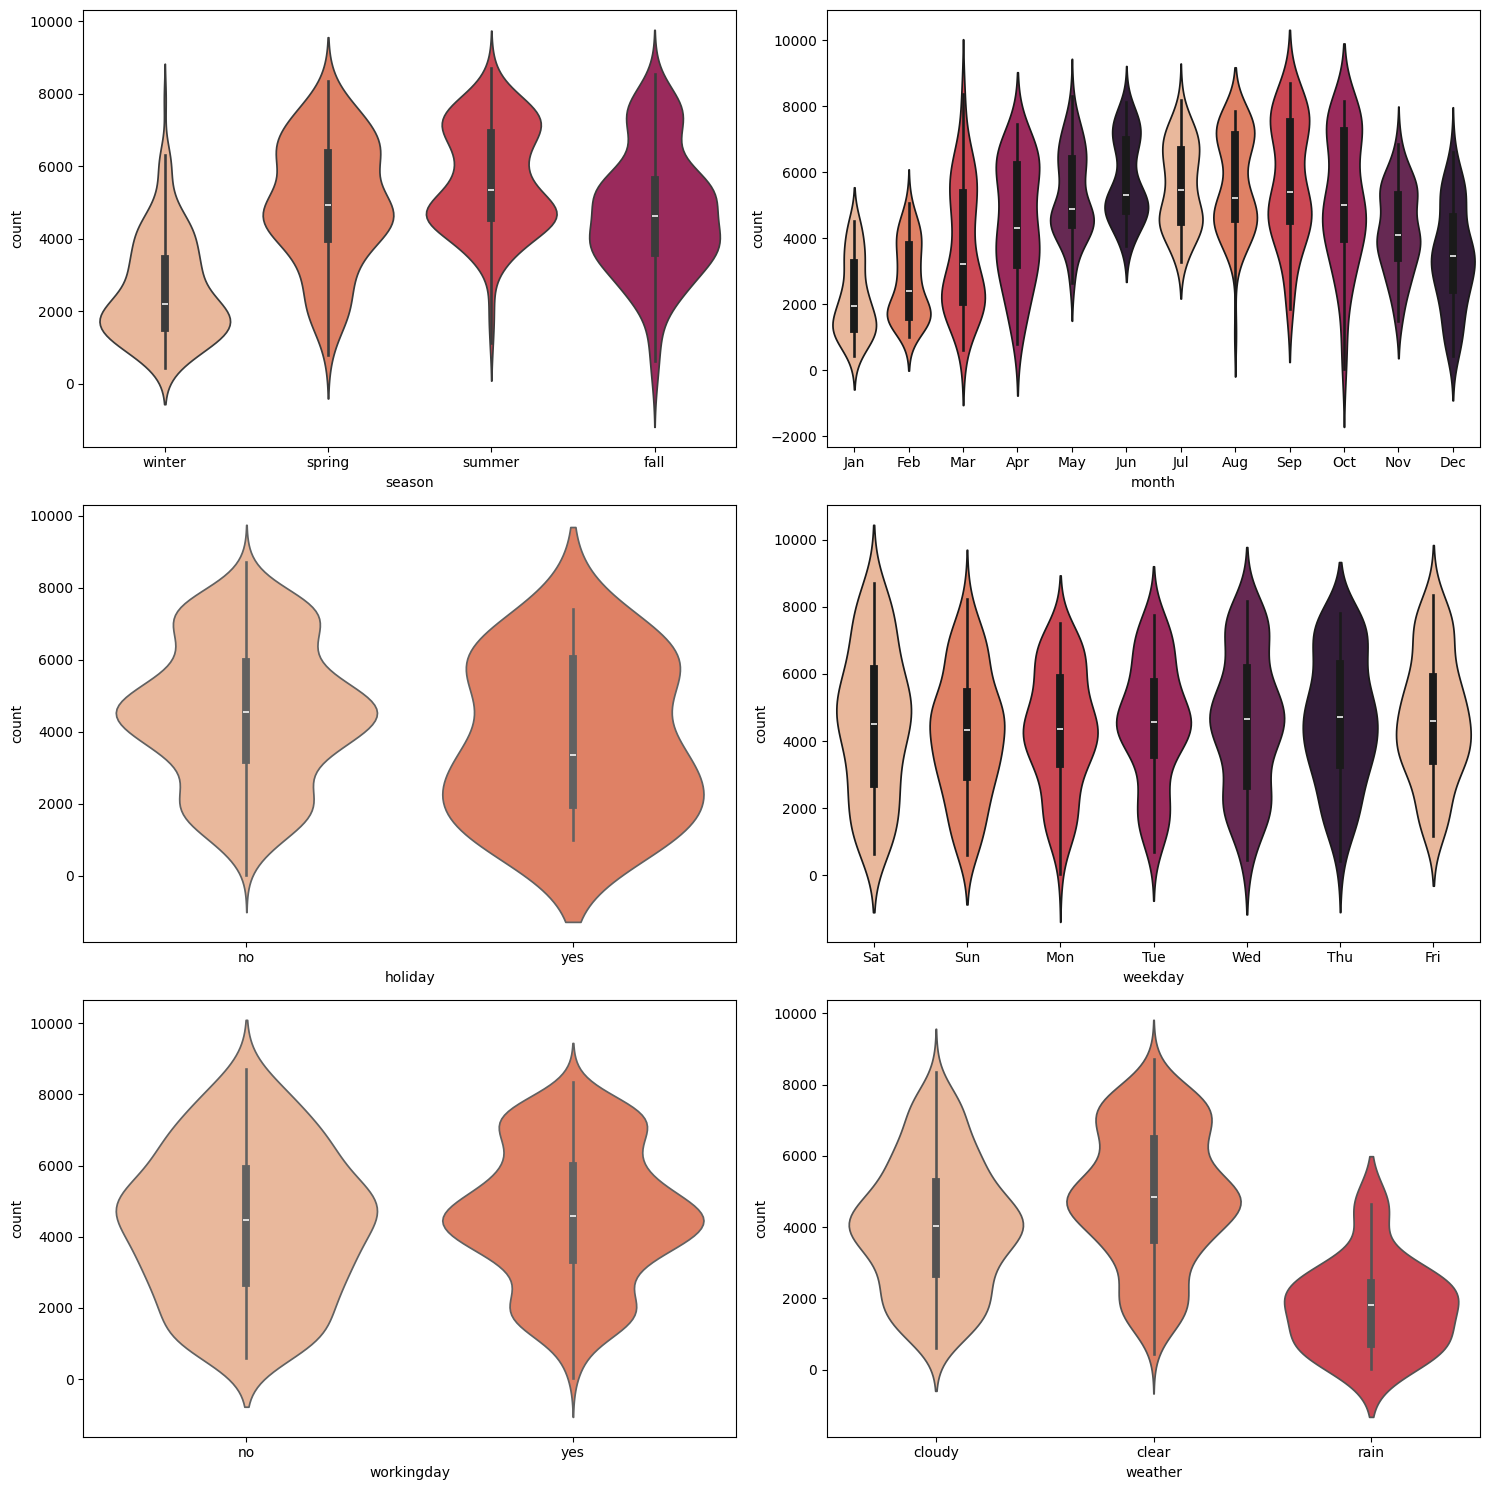

In [31]:
plt.figure(figsize=(15,15))
for i, col in enumerate(["season", "month", "holiday", "weekday", "workingday", "weather"]):
    plt.subplot(3,2, i+1)
    sns.violinplot(x=daily_data2[col], y=daily_data2["count"], hue=daily_data2[col], palette=sns.color_palette("rocket_r"))
plt.tight_layout()
plt.show()

1. Season
    * in winter, the total rides are low compared to other seasons
    * Spring and autum has highest no. of bike ride samples
2. Months
    * Start of year has lesser ride
    * We get most rides during March to October
    * May, June and July has a minimun rides of around 1000
3. Holidays
    * During holidays, the bike rentals request are high
    * There is a particular time period where it not a holiday yet the no. of request is high
4. Weekday
    * Usually weekends has most no. of ride request, but does not vary much compared to weekdays
5. Working day
    * High no. of rides in non-working days
    * There is a sharp buldge for working days as well -> There may users who use bike rental to reach work place
6. Weather
    * During rainy season, samples suggest that the no. of ride request is less
    * People prefer bike rental during clear clouds
    * bike rentals are slightly less while cloudy compared to clear weather
    * rain < cloudy < clear sky

In [32]:
hour_data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            17379 non-null  object 
 1   season          17379 non-null  object 
 2   year            17379 non-null  int64  
 3   month           17379 non-null  object 
 4   hr              17379 non-null  int64  
 5   holiday         17379 non-null  object 
 6   weekday         17379 non-null  object 
 7   workingday      17379 non-null  object 
 8   weather         17379 non-null  object 
 9   temperature     17379 non-null  float64
 10  feel_like_temp  17379 non-null  float64
 11  humidity        17379 non-null  float64
 12  windspeed       17379 non-null  float64
 13  casual          17379 non-null  int64  
 14  registered      17379 non-null  int64  
 15  count           17379 non-null  int64  
dtypes: float64(4), int64(5), object(7)
memory usage: 2.1+ MB


<Axes: xlabel='hr', ylabel='count'>

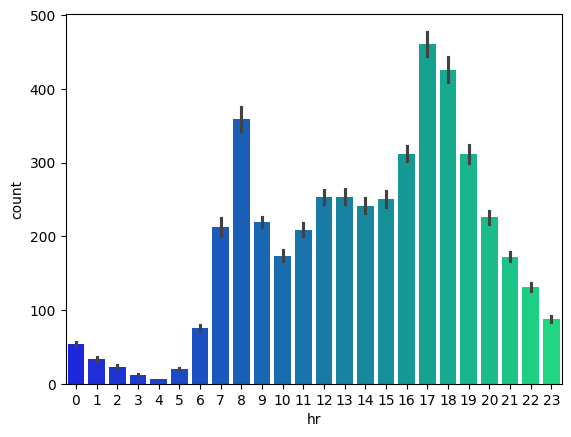

In [33]:
sns.barplot(x=hour_data2["hr"], y = hour_data2["count"], palette='winter')

* Peak hours for rental bike demand starts from morning 7 to evening 8
* There is high demand during 8AM, where people tend to reach office and evening 5-6 when people log off 

In [34]:
daily_data2.columns

Index(['date', 'season', 'year', 'month', 'holiday', 'weekday', 'workingday',
       'weather', 'temperature', 'feel_like_temp', 'humidity', 'windspeed',
       'casual', 'registered', 'count'],
      dtype='object')

In [35]:
plt.colormaps()

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'grey',
 'gist_grey',
 'gist_yerg',
 'Grays',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viri

<Axes: >

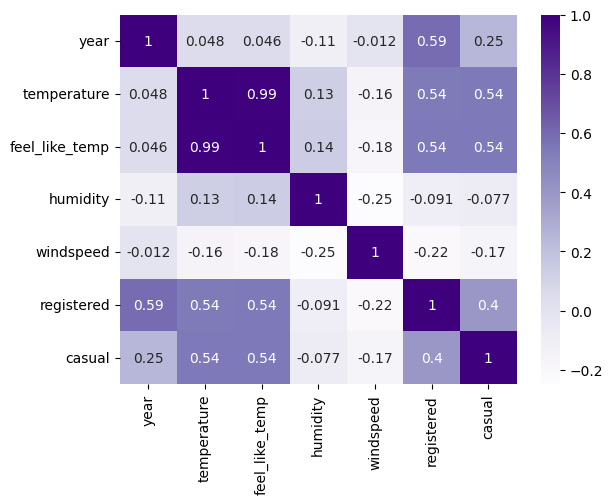

In [36]:
sns.heatmap(daily_data2[["year", "temperature", "feel_like_temp", "humidity", "windspeed", "registered", "casual"]].corr(), annot=True, cmap='Purples')

* Registered column has high corelation with count
* temperature and feel-like temperature have very high corelation within. can  drop one of them
* No other columns have high corelation with other predectors except temperature and feel-like temperature
* Humidity and windspeed have least corelation with target count. Not droping these columns since these help in Time-series algorithms

### Model hourly data

#### Data pre-processing for modeling

In [37]:
hour_data.columns

Index(['date', 'season', 'year', 'month', 'hr', 'holiday', 'weekday',
       'workingday', 'weather', 'temperature', 'feel_like_temp', 'humidity',
       'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [38]:
daily_data.columns

Index(['date', 'season', 'year', 'month', 'holiday', 'weekday', 'workingday',
       'weather', 'temperature', 'feel_like_temp', 'humidity', 'windspeed',
       'casual', 'registered', 'count'],
      dtype='object')

In [39]:
one_hot_cols = ["season","month", "weekday", "weather"]

In [40]:
# droping casual
scale_down_cols = ['registered', "count"]

In [41]:
# One-hot encoding
from sklearn.preprocessing import OneHotEncoder

In [42]:
one_hot = OneHotEncoder(dtype = np.int64, sparse_output=False)

In [43]:
a = pd.DataFrame(one_hot.fit_transform(hour_data[one_hot_cols]), columns=one_hot.get_feature_names_out(), )

In [44]:
# min-max scalar
from sklearn.preprocessing import MinMaxScaler

In [45]:
min_max = MinMaxScaler()

In [46]:
scaled_data = min_max.fit_transform(hour_data[scale_down_cols])

In [47]:
scaled_data = pd.DataFrame(scaled_data, columns= min_max.get_feature_names_out())

In [48]:
one_hot_cols + scale_down_cols

['season', 'month', 'weekday', 'weather', 'registered', 'count']

In [49]:
hour_data3 = hour_data.copy()

In [50]:
hour_data3.drop(one_hot_cols + scale_down_cols, axis=1, inplace=True)

In [51]:
hour_data3 = hour_data3.join([a,scaled_data])

In [52]:
hour_data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 39 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            17379 non-null  object 
 1   year            17379 non-null  int64  
 2   hr              17379 non-null  int64  
 3   holiday         17379 non-null  int64  
 4   workingday      17379 non-null  int64  
 5   temperature     17379 non-null  float64
 6   feel_like_temp  17379 non-null  float64
 7   humidity        17379 non-null  float64
 8   windspeed       17379 non-null  float64
 9   casual          17379 non-null  int64  
 10  season_1        17379 non-null  int64  
 11  season_2        17379 non-null  int64  
 12  season_3        17379 non-null  int64  
 13  season_4        17379 non-null  int64  
 14  month_1         17379 non-null  int64  
 15  month_2         17379 non-null  int64  
 16  month_3         17379 non-null  int64  
 17  month_4         17379 non-null 

In [53]:
# We can extract date(1-31) from date column, but droping for now to check how model performs
# Droping count column since we are training to predict casual and registered
# Droping feel-like-temp since it has high corelation with temperature
# Droping humidity and windspeed since these columns has nothing to contribute to build model
hour_data3.drop(["date", 'feel_like_temp', 'casual', 'humidity', 'windspeed'], axis=1, inplace=True)


<Axes: >

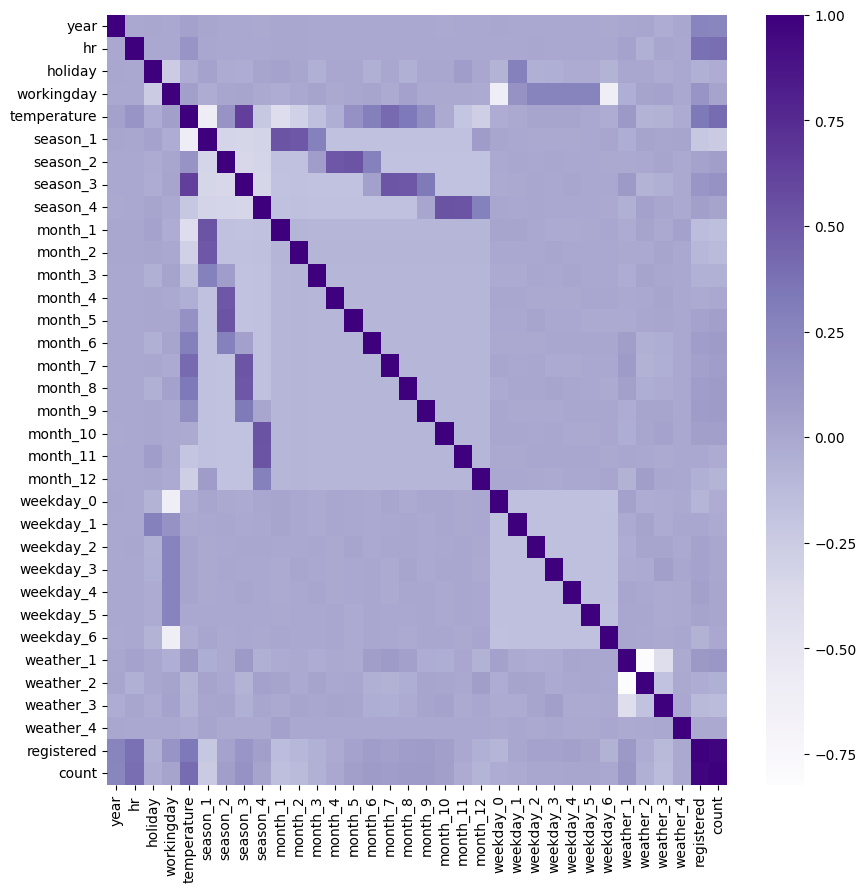

In [54]:
plt.figure(figsize=(10,10))
sns.heatmap(hour_data3.corr(), annot=False, cmap='Purples' )

In [55]:
hour_data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 34 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         17379 non-null  int64  
 1   hr           17379 non-null  int64  
 2   holiday      17379 non-null  int64  
 3   workingday   17379 non-null  int64  
 4   temperature  17379 non-null  float64
 5   season_1     17379 non-null  int64  
 6   season_2     17379 non-null  int64  
 7   season_3     17379 non-null  int64  
 8   season_4     17379 non-null  int64  
 9   month_1      17379 non-null  int64  
 10  month_2      17379 non-null  int64  
 11  month_3      17379 non-null  int64  
 12  month_4      17379 non-null  int64  
 13  month_5      17379 non-null  int64  
 14  month_6      17379 non-null  int64  
 15  month_7      17379 non-null  int64  
 16  month_8      17379 non-null  int64  
 17  month_9      17379 non-null  int64  
 18  month_10     17379 non-null  int64  
 19  mont

#### Train test split

In [56]:
from sklearn.model_selection import train_test_split

In [57]:
hour_data3.columns

Index(['year', 'hr', 'holiday', 'workingday', 'temperature', 'season_1',
       'season_2', 'season_3', 'season_4', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'weekday_0', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
       'weather_1', 'weather_2', 'weather_3', 'weather_4', 'registered',
       'count'],
      dtype='object')

In [58]:
hour_data3.shape

(17379, 34)

In [59]:
hy = hour_data3.iloc[:,-2:]

In [60]:
hx = hour_data3.iloc[:,:-2]

In [61]:
hx_train, hx_test, hy_train, hy_test = train_test_split(hx, hy, test_size=0.2, shuffle=True)

#### PCA

We are applying PCA to reduce the number of features.<br/>
To identify feature importance we can use Decission tree on pre-processed data

In [62]:
from sklearn.decomposition  import PCA

In [63]:
pca = PCA()

In [64]:
pca.fit_transform(hour_data3, )

array([[-1.15474780e+01,  1.59825866e-01, -1.30782443e+00, ...,
         9.25093335e-14, -2.94653191e-13, -1.47659662e-14],
       [-1.05472111e+01,  1.54612324e-01, -1.30880587e+00, ...,
         7.40518757e-14, -2.19768648e-13, -1.33226763e-14],
       [-9.54746570e+00,  1.49314975e-01, -1.31046367e+00, ...,
         8.66112737e-14, -2.67008637e-13, -1.48769885e-14],
       ...,
       [ 9.45152162e+00, -5.03491633e-02, -1.97476588e-01, ...,
        -3.73562292e-13,  4.86666263e-13,  1.63202785e-14],
       [ 1.04507255e+01, -5.81962516e-02, -2.02525932e-01, ...,
        -4.24243973e-13,  6.78013201e-13,  2.27595720e-14],
       [ 1.14503647e+01, -6.39920026e-02, -2.04851357e-01, ...,
        -4.25340319e-13,  6.82010004e-13,  2.29816166e-14]])

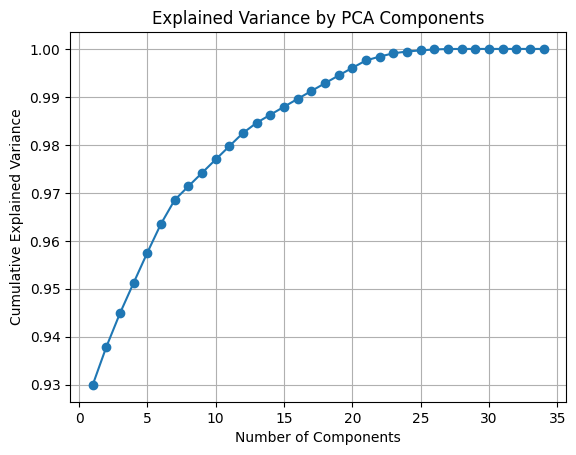

In [65]:
explained = np.cumsum(pca.explained_variance_ratio_)


plt.plot(range(1, len(explained)+1), explained, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.title('Explained Variance by PCA Components')
plt.show()

Using 11 PCA components that explains 98% of data

In [66]:
pca = PCA(n_components=11)

In [67]:
hx_pca = pca.fit_transform(hx_train, )

In [68]:
hx_train = pd.DataFrame(hx_pca)

In [69]:
hx_test = pd.DataFrame(pca.fit_transform(hx_test))

#### Model training

In [70]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score, mean_squared_error 

In [71]:
pipeline = Pipeline([("model", DummyRegressor())])

In [72]:
models = {
    # "Ridge":{"model":[MultiOutputRegressor(Ridge())]},
    # "LinearRegression":{"model":[MultiOutputRegressor(LinearRegression())]},
    # "SVR":{"model":[MultiOutputRegressor(SVR())]},
    # "KNeighborsRegressor":{"model":[MultiOutputRegressor(KNeighborsRegressor())]},
    # "DecisionTreeRegressor":{"model":[MultiOutputRegressor(DecisionTreeRegressor())]},
    # "RandomForestRegressor":{"model":[MultiOutputRegressor(RandomForestRegressor())]},
    # "BaggingRegressor":{"model":[MultiOutputRegressor(BaggingRegressor())]},
    "ExtraTreesRegressor":{"model":[MultiOutputRegressor(ExtraTreesRegressor())]},
    # "GradientBoostingRegressor":{"model":[MultiOutputRegressor(GradientBoostingRegressor())]},
    # "XGBRegressor" : {"model":[MultiOutputRegressor(XGBRegressor())]},
    # "LGBMRegressor" : {"model":[MultiOutputRegressor(LGBMRegressor())]},
    # "CatBoostRegressor":{"model":[MultiOutputRegressor(CatBoostRegressor())]}
}

In [73]:
def adjusted_r2_multi(y_true, y_pred, n_features):
    r2_vals = r2_score(y_true, y_pred, multioutput='raw_values')
    n = y_true.shape[0]
    return [1 - ((1 - r2) * (n - 1)) / (n - n_features - 1) for r2 in r2_vals]

In [74]:
import os
os.makedirs('catboost_logs', exist_ok=True)

In [75]:
result = {}
for model_name, model_param in models.items():
    print("modeling -", model_name)
    grid = GridSearchCV(pipeline, param_grid=model_param, scoring = "r2", cv=2, verbose=1, n_jobs=-1, error_score='raise')
    grid.fit(hx_train, hy_train)
    
    pred_train = grid.predict(hx_train)
    pred_test = grid.predict(hx_test)

    rmse_train = np.sqrt(mean_squared_error(hy_train, pred_train))
    rmse_test = np.sqrt(mean_squared_error(hy_test, pred_test))

    r2_train = r2_score(hy_train, pred_train, multioutput="raw_values")
    r2_test = r2_score(hy_test, pred_test, multioutput="raw_values")

    adjR2_train = adjusted_r2_multi(hy_train, pred_train,2)
    adjR2_test = adjusted_r2_multi(hy_test, pred_test,2)

    train_time = np.average(grid.cv_results_['mean_fit_time'])

    result[model_name] = {
        "train_time":train_time,
        "best_score":grid.best_score_,
        "r2_train":r2_train,
        "r2_test":r2_test,
        "adjR2_train":r2_train,
        "adjR2_test":adjR2_test,
        "rmse_train":rmse_train,
        "rmse_test":rmse_test
    }
    
    

modeling - ExtraTreesRegressor
Fitting 2 folds for each of 1 candidates, totalling 2 fits


In [76]:
res = pd.DataFrame(result)

In [77]:
res.round(decimals=4).T

,train_time,best_score,r2_train,r2_test,adjR2_train,adjR2_test,rmse_train,rmse_test
ExtraTreesRegressor,5.398918,0.917003,"[0.998434301394478, 0.9985702045512059]","[0.770559558086992, 0.7643145185630501]","[0.998434301394478, 0.9985702045512059]","[0.770427429989144, 0.7641787941280158]",0.006907,0.085498


* Linear Regression, Ridge and SVR have less learning rate
* KNeighborsRegressor has very less learning rate, decent learning and prediction
* All tree based models are learning data well, but prediction accuracy is less (better that linear models)
* RandomForestRegressor takes highest training time
* Best prediction are given by KNeighborsRegressor and ExtraTreesRegressor. But ExtraTreesRegressor has the scope to regularise using hyperParameters
* Finding sutable hyperparameter for ExtraTreesRegressor is time consuming (5.6 sec/model)
* GPU enabled models are having good learning but prediction % is less

Considering ExtraTreesRegressor

In [ ]:

tree_params = {
    "estimator__n_estimators" : [100, 50,130],
    "estimator__max_depth" : [None,10,20],
    "estimator__min_samples_split" : [2,50,100],
    "estimator__min_samples_leaf" : [1,10,20],
    "estimator__max_features" : ["sqrt", "log2"],
    "estimator__max_leaf_nodes": [None, 10,40]
}

grid2 = GridSearchCV(MultiOutputRegressor(ExtraTreesRegressor(n_jobs=-1)), param_grid=tree_params, scoring = "r2", cv=4, verbose=3, n_jobs=-1, error_score='raise')

grid2.fit(hx_train, hy_train)

print("best_score :", grid2.best_score_)

lgbm_pred_test = grid2.predict(hx_test)
lgbm_pred_train = grid2.predict(hx_train)

r2_score(hy_train, lgbm_pred_train, multioutput="raw_values")

r2_score(hy_test, lgbm_pred_test, multioutput="raw_values")


In [ ]:
r2_score(hy_train, lgbm_pred_train, multioutput="raw_values")

In [ ]:
r2_score(hy_test, lgbm_pred_test, multioutput="raw_values")

In [ ]:
grid2.best_params_

On default settings ExtraTreeRegressor gives the best score (70-80%) based on multiple tests 

In [ ]:
et = MultiOutputRegressor(ExtraTreesRegressor())

In [ ]:
et.fit(hx_train, hy_train)

In [ ]:
et_pred = et.predict(hx_test)

In [ ]:
et_pred = min_max.inverse_transform(et_pred)

In [ ]:
et_pred = pd.DataFrame(et_pred.astype(int), columns=["registered", "count"])

In [ ]:
et_pred.loc[et_pred['registered']>et_pred['count'], :] = et_pred[['count']]

In [ ]:
et_pred['casual'] = et_pred['count'] - et_pred['registered']

### Conclusion

* Linear Regression, Ridge and SVR have less learning rate
* KNeighborsRegressor has very less learning rate, decent learning and prediction
* All tree based models are learning data well, but prediction accuracy is less (better that linear models)
* RandomForestRegressor takes highest training time
* Best prediction are given by KNeighborsRegressor and ExtraTreesRegressor. But ExtraTreesRegressor has the scope to regularise using hyperParameters
* Finding sutable hyperparameter for ExtraTreesRegressor is time consuming (5.6 sec/model)
* GPU enabled models are having good learning but prediction % is less

On default settings ExtraTreeRegressor gives the best score (70-80%) based on multiple tests.<br>
Considering ExtraTreesRegressor

## Time series modeling

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", message="ValueWarning")
%matplotlib inline

In [38]:
daily_data = pd.read_csv("day.csv")

In [39]:
daily_data.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [40]:
# column renames
rename_dic = {
    'dteday':"date",
    'yr': "year",
    "mnth": "month",
    "weathersit": "weather",
    "temp": "temperature",
    "atemp": "feel_like_temp",
    "hum": "humidity",
    'cnt': "count"
}
daily_data.rename(rename_dic, axis=1, inplace=True)

In [41]:
daily_data

,instant,date,season,year,month,holiday,weekday,workingday,weather,temperature,feel_like_temp,humidity,windspeed,casual,registered,count
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


In [42]:
daily_data.drop(["instant"], axis=1, inplace=True)

#### preprocess
encode month, weekday as cyclic

In [43]:
# Cyclical encoding
# sin with cos together  allows models to "feel" the cyclical relationship (e.g., December is close to January).
daily_data['month_sin'] = np.sin(2 * np.pi * daily_data['month'] / 12)
daily_data['month_cos'] = np.cos(2 * np.pi * daily_data['month'] / 12)

daily_data['weekday_sin'] = np.sin(2 * np.pi * daily_data['weekday'] / 7)
daily_data['weekday_cos'] = np.cos(2 * np.pi * daily_data['weekday'] / 7)

daily_data.drop(["month","weekday"], axis=1, inplace=True)
                

In [44]:
# season and weather encoding
season_map = {1:4, 4:6, 2:7, 3:10}
weather_map = {4:1, 3:7, 2:10, 1:20}

daily_data["season"] = daily_data["season"].map(season_map)
daily_data["weather"] = daily_data["weather"].map(weather_map)

In [45]:
target_cols = ['casual','registered', 'count']

from sklearn.preprocessing import MinMaxScaler

min_max = MinMaxScaler()

daily_data[target_cols] = min_max.fit_transform(daily_data[target_cols])

In [46]:
daily_data["date"] = pd.to_datetime(daily_data["date"])
print(daily_data['date'].is_monotonic_increasing)

daily_data.set_index("date", inplace=True)

daily_data.head(2)

True


,season,year,holiday,workingday,weather,temperature,feel_like_temp,humidity,windspeed,casual,registered,count,month_sin,month_cos,weekday_sin,weekday_cos
date,,,,,,,,,,,,,,,,
2011-01-01,4,0,0,0,10,0.344167,0.363625,0.805833,0.160446,0.096538,0.091539,0.110792,0.5,0.866025,-0.781831,0.62349
2011-01-02,4,0,0,0,10,0.363478,0.353739,0.696087,0.248539,0.037852,0.093849,0.089623,0.5,0.866025,0.000000,1.00000


In [47]:
y = daily_data[target_cols].values
x = daily_data.drop(columns=target_cols).values

In [48]:
# 5. Create sequences
def create_sequences(X, y, time_steps=7):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

In [49]:
time_steps = 7
X_seq, y_seq = create_sequences(x, y, time_steps)

In [51]:
X_seq.shape

(724, 7, 13)

In [61]:
X_seq

array([[[ 4.        ,  0.        ,  0.        , ...,  0.8660254 ,
         -0.78183148,  0.6234898 ],
        [ 4.        ,  0.        ,  0.        , ...,  0.8660254 ,
          0.        ,  1.        ],
        [ 4.        ,  0.        ,  0.        , ...,  0.8660254 ,
          0.78183148,  0.6234898 ],
        ...,
        [ 4.        ,  0.        ,  0.        , ...,  0.8660254 ,
          0.43388374, -0.90096887],
        [ 4.        ,  0.        ,  0.        , ...,  0.8660254 ,
         -0.43388374, -0.90096887],
        [ 4.        ,  0.        ,  0.        , ...,  0.8660254 ,
         -0.97492791, -0.22252093]],

       [[ 4.        ,  0.        ,  0.        , ...,  0.8660254 ,
          0.        ,  1.        ],
        [ 4.        ,  0.        ,  0.        , ...,  0.8660254 ,
          0.78183148,  0.6234898 ],
        [ 4.        ,  0.        ,  0.        , ...,  0.8660254 ,
          0.97492791, -0.22252093],
        ...,
        [ 4.        ,  0.        ,  0.        , ...,  

In [54]:
x

array([[ 4.        ,  0.        ,  0.        , ...,  0.8660254 ,
        -0.78183148,  0.6234898 ],
       [ 4.        ,  0.        ,  0.        , ...,  0.8660254 ,
         0.        ,  1.        ],
       [ 4.        ,  0.        ,  0.        , ...,  0.8660254 ,
         0.78183148,  0.6234898 ],
       ...,
       [ 4.        ,  1.        ,  0.        , ...,  1.        ,
        -0.78183148,  0.6234898 ],
       [ 4.        ,  1.        ,  0.        , ...,  1.        ,
         0.        ,  1.        ],
       [ 4.        ,  1.        ,  0.        , ...,  1.        ,
         0.78183148,  0.6234898 ]])

In [55]:
x.shape

(731, 13)

In [15]:
# 6. Train-test split (keep temporal order)
split_idx = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [17]:
# 7. Build LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(LSTM(64, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))

model.add(LSTM(64, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(LSTM(128, return_sequences=True, activation='tanh'))
# model.add(LSTM(128, activation='tanh'))
model.add(Dense(3))  # Multi-output: casual, registered, count
model.compile(optimizer='adam', loss='mse')

In [18]:
# 8. Train
from tensorflow.keras.callbacks import EarlyStopping
# early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=7, verbose=1)


Epoch 1/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0398 - val_loss: 0.0546
Epoch 2/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0195 - val_loss: 0.0328
Epoch 3/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0153 - val_loss: 0.0344
Epoch 4/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0133 - val_loss: 0.0290
Epoch 5/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0118 - val_loss: 0.0213
Epoch 6/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0104 - val_loss: 0.0250
Epoch 7/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0106 - val_loss: 0.0208
Epoch 8/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0113 - val_loss: 0.0230
Epoch 9/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - val_loss: 0.0340
Epoch 10/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0110 - val_loss: 0.0287
Epoch 11/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0109 - val_loss: 0.0233
Epoch 12/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0099 - val_l

In [19]:
# 9. Evaluate
y_pred_scaled = model.predict(X_test)
y_pred = min_max.inverse_transform(y_pred_scaled)
y_true = min_max.inverse_transform(y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step 


In [20]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_true, y_pred)
print(mae)

1059.2142729660561


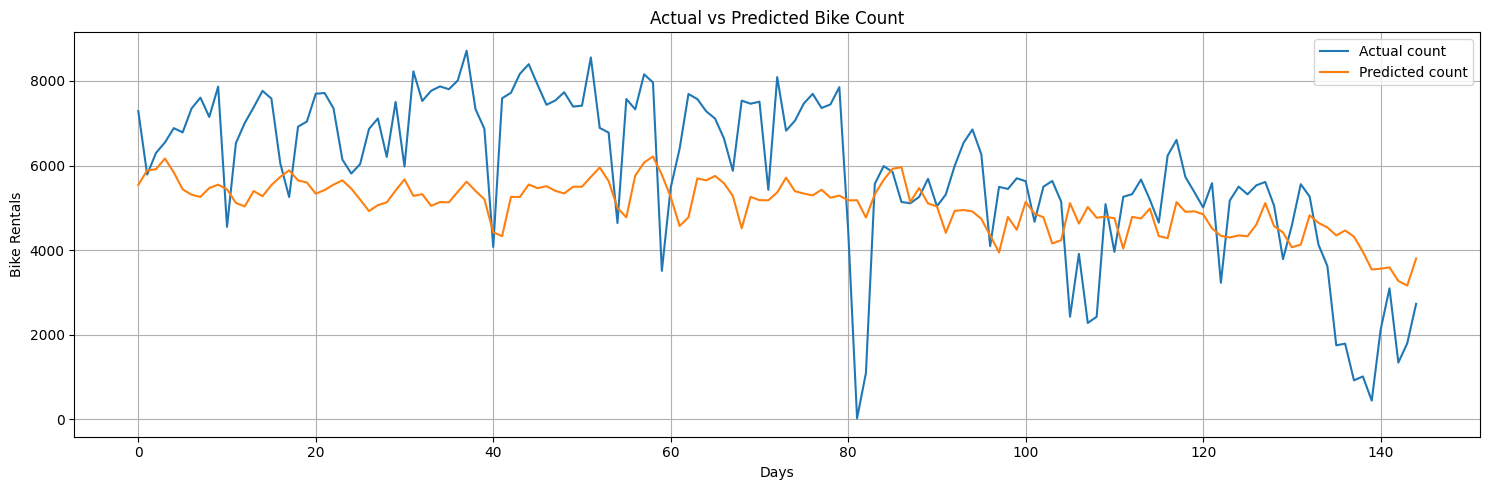

In [21]:
# 10. Plot results
plt.figure(figsize=(15, 5))
plt.plot(y_true[:, 2], label="Actual count")
plt.plot(y_pred[:, 2], label="Predicted count")
plt.title("Actual vs Predicted Bike Count")
plt.xlabel("Days")
plt.ylabel("Bike Rentals")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

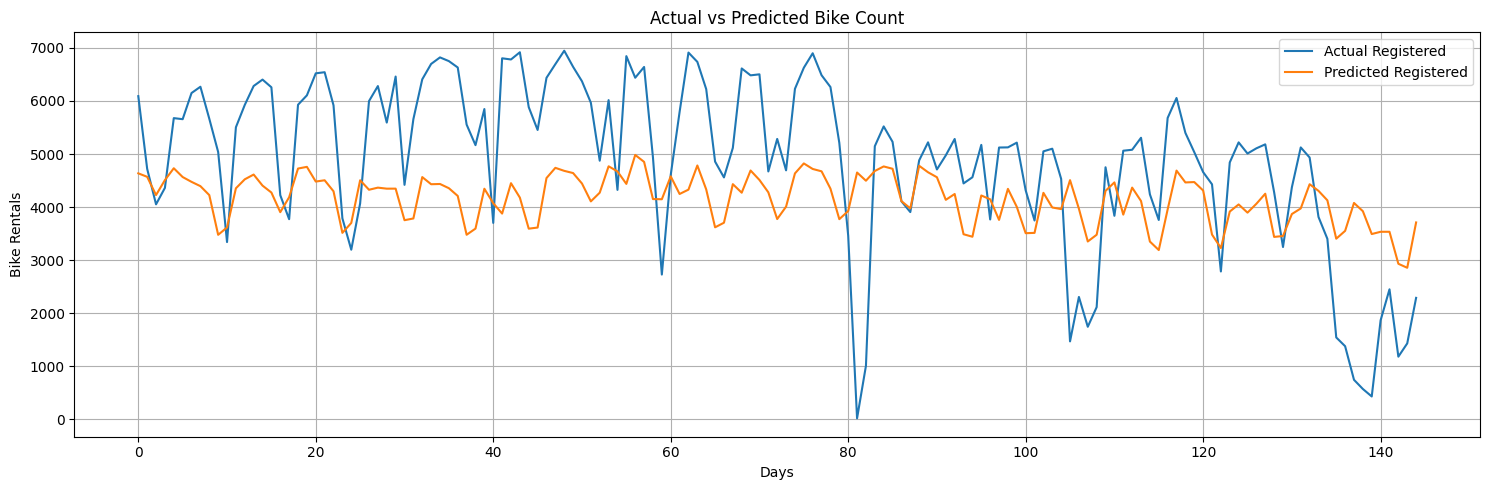

In [22]:
# 10. Plot results
plt.figure(figsize=(15, 5))
plt.plot(y_true[:, 1], label="Actual Registered")
plt.plot(y_pred[:, 1], label="Predicted Registered")
plt.title("Actual vs Predicted Bike Count")
plt.xlabel("Days")
plt.ylabel("Bike Rentals")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

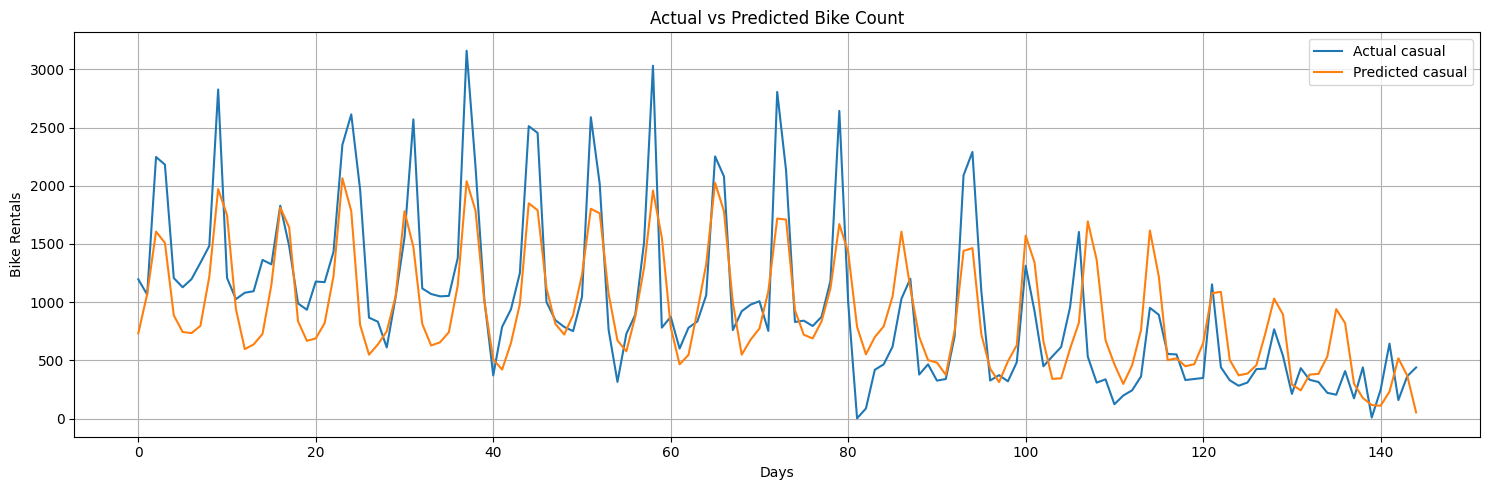

In [26]:
# 10. Plot results
plt.figure(figsize=(15, 5))
plt.plot(y_true[:, 0], label="Actual casual")
plt.plot(y_pred[:, 0], label="Predicted casual")
plt.title("Actual vs Predicted Bike Count")
plt.xlabel("Days")
plt.ylabel("Bike Rentals")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

LSTM dosent fit well for this problem

#### SARIMAX

In [28]:
daily_data_ts = pd.read_csv("day.csv")

In [29]:
# column renames
rename_dic = {
    'dteday':"date",
    'yr': "year",
    "mnth": "month",
    "weathersit": "weather",
    "temp": "temperature",
    "atemp": "feel_like_temp",
    "hum": "humidity",
    'cnt': "count"
}
daily_data_ts.rename(rename_dic, axis=1, inplace=True)

In [30]:
daily_data_ts["date"] = pd.to_datetime(daily_data_ts["date"])
print(daily_data_ts['date'].is_monotonic_increasing)

daily_data_ts.set_index("date", inplace=True)

daily_data_ts.head(2)

True


,instant,season,year,month,holiday,weekday,workingday,weather,temperature,feel_like_temp,humidity,windspeed,casual,registered,count
date,,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2011-01-02,2,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801


In [31]:
# Cyclical encoding
# sin with cos together  allows models to "feel" the cyclical relationship (e.g., December is close to January).
daily_data_ts['month_sin'] = np.sin(2 * np.pi * daily_data_ts['month'] / 12)
daily_data_ts['month_cos'] = np.cos(2 * np.pi * daily_data_ts['month'] / 12)

daily_data_ts['weekday_sin'] = np.sin(2 * np.pi * daily_data_ts['weekday'] / 7)
daily_data_ts['weekday_cos'] = np.cos(2 * np.pi * daily_data_ts['weekday'] / 7)

daily_data_ts.drop(["month","weekday"], axis=1, inplace=True)

In [32]:
season_map = {1:4, 4:6, 2:7, 3:10}
weather_map = {3:7, 2:10, 1:20}

daily_data_ts["season"] = daily_data_ts["season"].map(season_map)
daily_data_ts["weather"] = daily_data_ts["weather"].map(weather_map)

In [33]:
y = daily_data_ts["count"]
x = daily_data_ts.drop(columns=["count"])

In [34]:
from sklearn.preprocessing import MinMaxScaler

min_max = MinMaxScaler()

daily_data_ts["count"] = min_max.fit_transform(daily_data_ts[["count"]])
daily_data_ts.drop(columns=["casual", "registered","instant"], inplace=True)

In [35]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
daily_data_ts.columns

Index(['season', 'year', 'holiday', 'workingday', 'weather', 'temperature',
       'feel_like_temp', 'humidity', 'windspeed', 'count', 'month_sin',
       'month_cos', 'weekday_sin', 'weekday_cos'],
      dtype='object')

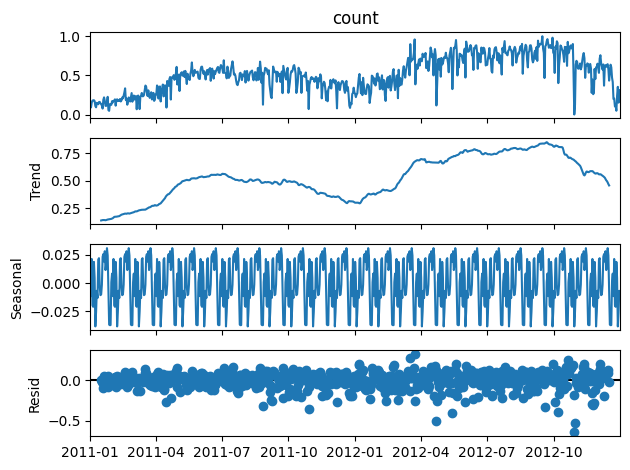

In [36]:
seasonal_decompose(daily_data["count"], period=30).plot();

In [37]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

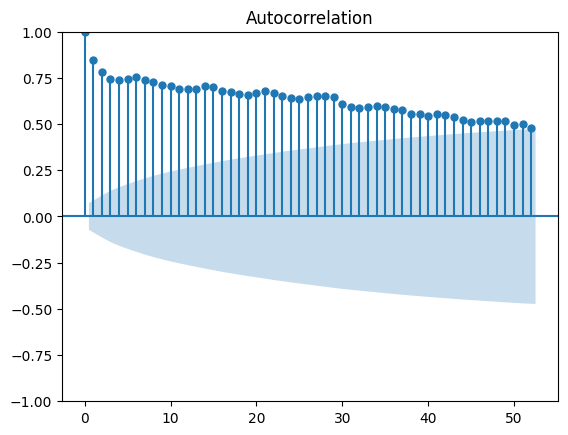

In [38]:
plot_acf(y, lags=52);

From above graph we can say that the data is not stationary.<br/>
beyond the lag 2 the data falls under confidence level -> current time stamp is dependant on past 52 data
1. The autocorrelation decays slowly — non-stationary time series 

In [39]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(y, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

# If p-value > 0.05 → series is non-stationary → apply differencing.

1. ADF :  -1.8774481444374298
2. P-Value :  0.34274344033921944
3. Num Of Lags :  13
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 717
5. Critical Values :
	 1% :  -3.439503230053971
	 5% :  -2.8655794463678346
	 10% :  -2.5689210707289982


In [40]:
# making data stationary by taking diff
diffed_series = y.diff().dropna()

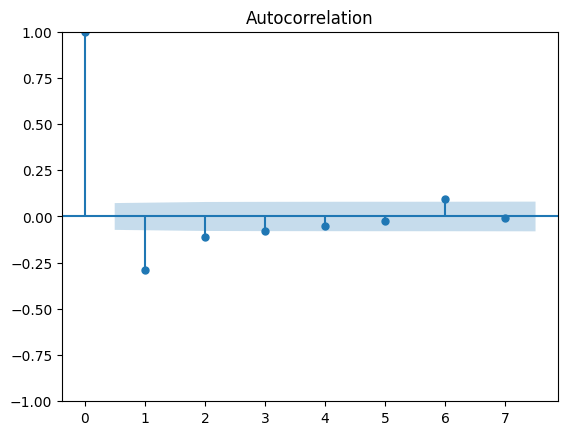

In [41]:
plot_acf(diffed_series, lags=7);

No Auto corelation. Stationarity removed<br>
the 7th value is relating with 0th value. if 0th value is monday, monday demand is reflected in 0th and 6th  day

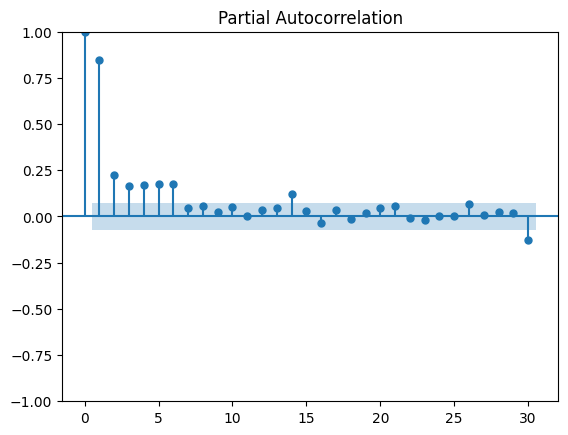

In [42]:
plot_pacf(y, lags=30);

pacf indicates that first 6 values are strongly influencing in identifying current demand<br>
p = [6,14]<br>
d = 1 (differencing)<br>
q = [2]

In [43]:
# 6. Train-test split (keep temporal order)
split_idx = int(len(X_seq) * 0.8)
X_train, X_test =x[:split_idx], x[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [44]:
from statsmodels.tsa.arima.model import ARIMA

In [45]:
results = []

In [46]:
p = [6,14]
d = [1,2]
q = [2,3]

In [47]:
import itertools
from tqdm import tqdm
pdq_combinations = list(itertools.product(p, d, q))

In [48]:
for param in tqdm(pdq_combinations):
    try:
        model = ARIMA(y_train, order=param)
        model_fit = model.fit()
        results.append({
            'order': param,
            'aic': model_fit.aic,
            'bic': model_fit.bic,
            'loglik': model_fit.llf
        })
    except Exception as e:
        print(f"Failed to fit ARIMA{param}: {e}")
        continue

D:\anacondaInstalled\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anacondaInstalled\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anacondaInstalled\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anacondaInstalled\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anacondaInstalled\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D w

In [49]:
pd.DataFrame(results)

,order,aic,bic,loglik
0,"(6, 1, 2)",9439.682949,9478.919114,-4710.841475
1,"(6, 1, 3)",9440.651158,9484.246897,-4710.325579
2,"(6, 2, 2)",9442.455672,9481.676252,-4712.227836
3,"(6, 2, 3)",9453.412912,9496.991335,-4716.706456
4,"(14, 1, 2)",9453.404268,9527.517024,-4709.702134
5,"(14, 1, 3)",9455.426628,9533.898957,-4709.713314
6,"(14, 2, 2)",9446.846133,9520.929452,-4706.423067
7,"(14, 2, 3)",9453.785607,9532.226768,-4708.892804


 Best model: ARIMA(6, 1, 2)
Lowest AIC = best generalization trade-off

Good BIC, and log-likelihood is comparable to others

Models like (14, 1, 2) and (14, 1, 3) have higher log-likelihood but worse BIC, meaning they’re more complex with little gain

D:\anacondaInstalled\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anacondaInstalled\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anacondaInstalled\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


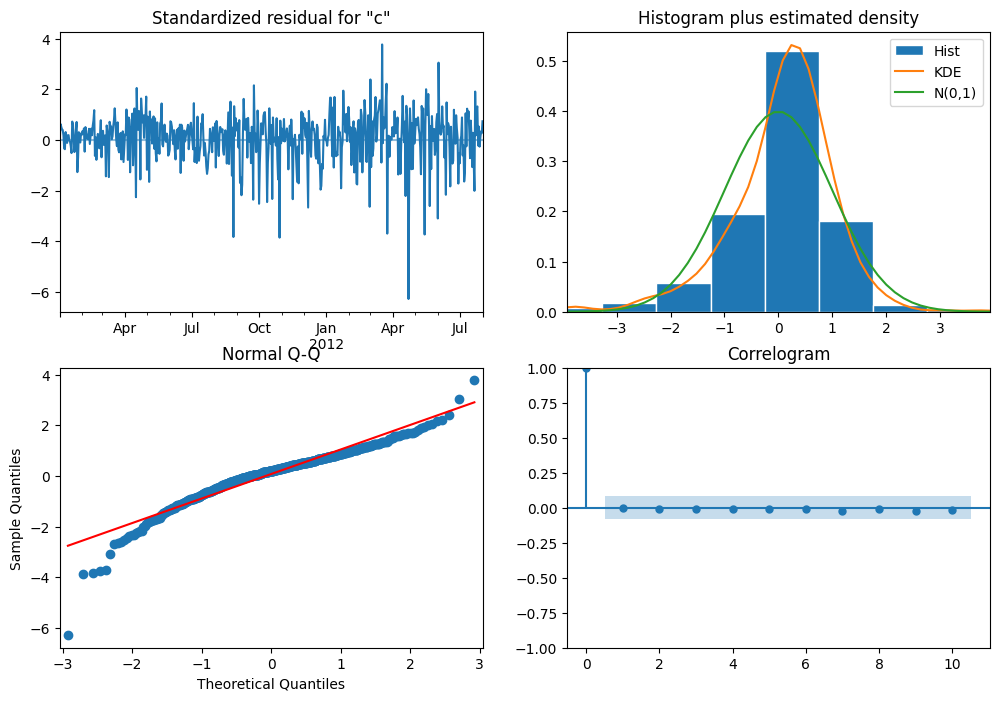

In [51]:
model_arima = ARIMA(y_train, order=(6,1,2))

model_arima_fit = model_arima.fit()

model_arima_fit.summary()

model_arima_fit.plot_diagnostics(figsize=(12,8));

* Residuals are centered.
* Compared to normal distribution, KDE is decent. not perfect
* All lags are within the blue confidence band.

In [52]:
y_test

date
2012-08-02    7261
2012-08-03    7175
2012-08-04    6824
2012-08-05    5464
2012-08-06    7013
              ... 
2012-12-27    2114
2012-12-28    3095
2012-12-29    1341
2012-12-30    1796
2012-12-31    2729
Name: count, Length: 152, dtype: int64

In [53]:
y_pred = model_arima_fit.forecast(steps=150)

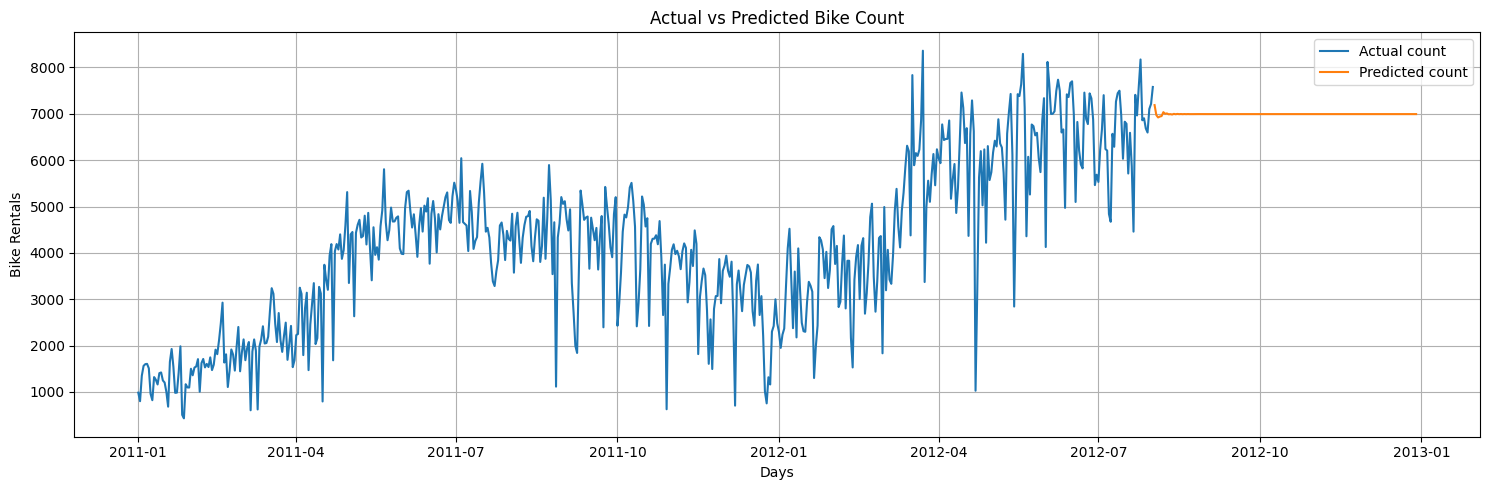

In [54]:
plt.figure(figsize=(15, 5))
plt.plot(y_train, label="Actual count")
plt.plot(y_pred, label="Predicted count")
plt.title("Actual vs Predicted Bike Count")
plt.xlabel("Days")
plt.ylabel("Bike Rentals")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show();

In practical ARIMA Dosent fit this data well

#### SARIMAX

In [57]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


sarima_model = SARIMAX(y_train,
                       exog=X_train,
                order=(6, 1, 2),               # non-seasonal ARIMA (p,d,q)
                seasonal_order=(1, 1, 1, 7),   # seasonal (P,D,Q,s)
                enforce_stationarity=False,
                enforce_invertibility=False)

sarima_model_fit = sarima_model.fit()

sarima_model_fit.summary()

D:\anacondaInstalled\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anacondaInstalled\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anacondaInstalled\envs\tf\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               count   No. Observations:                  579
Model:             SARIMAX(6, 1, 2)x(1, 1, [1], 7)   Log Likelihood                5910.660
Date:                             Mon, 19 May 2025   AIC                         -11767.321
Time:                                     16:12:28   BIC                         -11650.563
Sample:                                 01-01-2011   HQIC                        -11721.723
                                      - 08-01-2012                                         
Covariance Type:                               opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
instant                 0        nan        nan        nan         nan         nan
season          1.341e-13   1.57e-23   8.52e+09      0.000    1.34e-13    1.34e-13
year            3.112e-12   2.29e-23   1.36e+11      0.000    3.11e-12    3.11e-12
holiday         6.339e-14   3.06e-23   2.07e+09      0.000    6.34e-14    6.34e-14
workingday     -3.098e-14   3.06e-23  -1.01e+09      0.000    -3.1e-14    -3.1e-14
weather         8.177e-14   2.68e-21   3.06e+07      0.000    8.18e-14    8.18e-14
temperature    -5.571e-12   4.73e-23  -1.18e+11      0.000   -5.57e-12   -5.57e-12
feel_like_temp  7.745e-13   4.38e-23   1.77e+10      0.000    7.74e-13    7.74e-13
humidity       -4.182e-13   3.07e-23  -1.36e+10      0.000   -4.18e-13   -4.18e-13
windspeed      -2.105e-13   1.68e-23  -1.25e+10      0.000    -2.1e-13    -2.1e-13
casual             1.0000   1.74e-19   5.74e+18      0.000       1.000       1.000
registered         1.0000   6.11e-19   1.64e+18      0.000       1.000       1.000
month_sin      -6.821e-13   1.23e-23  -5.53e+10      0.000   -6.82e-13   -6.82e-13
month_cos       1.812e-13   4.27e-24   4.24e+10      0.000    1.81e-13    1.81e-13
weekday_sin             0   2.05e-39          0      1.000   -4.03e-39    4.03e-39
weekday_cos             0   8.69e-39          0      1.000    -1.7e-38     1.7e-38
ar.L1             -0.1920   9.12e-24  -2.11e+22      0.000      -0.192      -0.192
ar.L2             -0.1436   3.73e-23  -3.85e+21      0.000      -0.144      -0.144
ar.L3             -0.0639   6.17e-24  -1.04e+22      0.000      -0.064      -0.064
ar.L4              0.0391   2.38e-23   1.64e+21      0.000       0.039       0.039
ar.L5              0.1650   5.64e-23   2.92e+21      0.000       0.165       0.165
ar.L6              0.2584   1.46e-22   1.77e+21      0.000       0.258       0.258
ma.L1             -0.2443   6.68e-23  -3.66e+21      0.000      -0.244      -0.244
ma.L2             -0.0786    7.9e-23  -9.95e+20      0.000      -0.079      -0.079
ar.S.L7           -0.3108   2.64e-22  -1.18e+21      0.000      -0.311      -0.311
ma.S.L7           -0.4627   1.24e-21  -3.72e+20      0.000      -0.463      -0.463
sigma2              1e-10   8.39e-11      1.192      0.233   -6.44e-11    2.64e-10
===================================================================================
Ljung-Box (L1) (Q):                   0.77   Jarque-Bera (JB):                19.93
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular

In [60]:
y_pred = sarima_model_fit.forecast(steps=152, exog=X_test)

In [61]:
y_pred

2012-08-02    7261.0
2012-08-03    7175.0
2012-08-04    6824.0
2012-08-05    5464.0
2012-08-06    7013.0
               ...  
2012-12-27    2114.0
2012-12-28    3095.0
2012-12-29    1341.0
2012-12-30    1796.0
2012-12-31    2729.0
Freq: D, Name: predicted_mean, Length: 152, dtype: float64

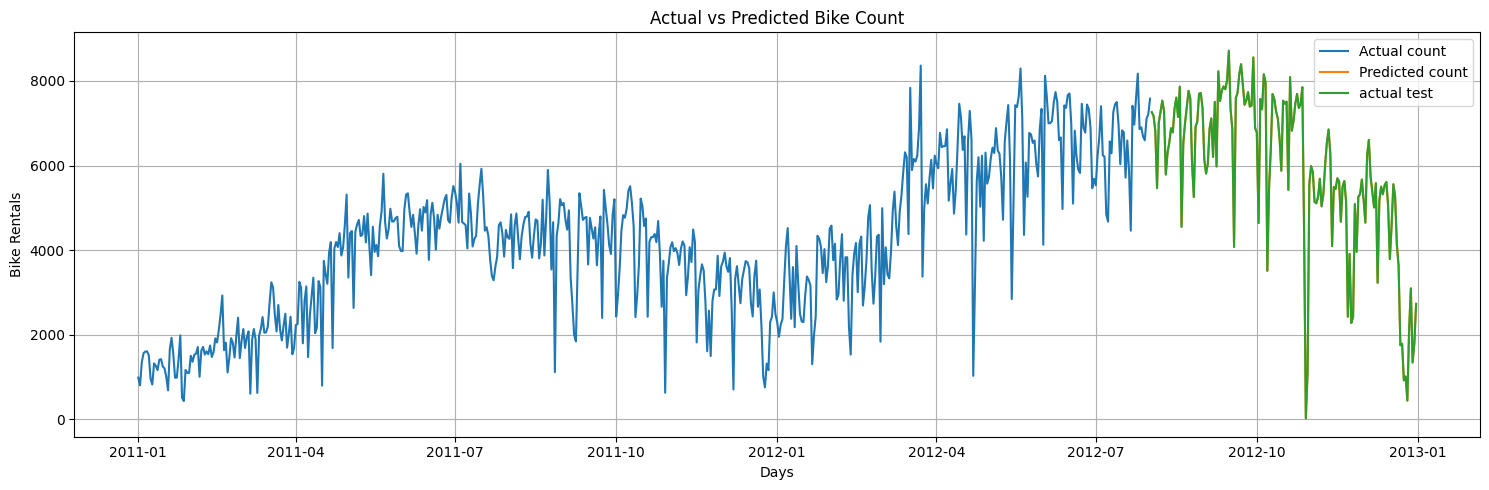

In [62]:
plt.figure(figsize=(15, 5))
plt.plot(y_train, label="Actual count")
plt.plot(y_pred, label="Predicted count")
plt.plot(y_test, label = "actual test")
plt.title("Actual vs Predicted Bike Count")
plt.xlabel("Days")
plt.ylabel("Bike Rentals")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show();

In [63]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)

print(mae)
print(rmse)

1.6345521427602331e-12
4.479266563157167e-24


Error is too less - > model is accurate

#### Prophet model

In [64]:
prophet_data = daily_data_ts.rename(columns={"date":"ds", "count":"y"})

prophet_data.head()

prophet_data.reset_index(inplace=True)

prophet_data.rename(columns={"date":"ds"}, inplace=True)

prophet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ds              731 non-null    datetime64[ns]
 1   season          731 non-null    int64         
 2   year            731 non-null    int64         
 3   holiday         731 non-null    int64         
 4   workingday      731 non-null    int64         
 5   weather         731 non-null    int64         
 6   temperature     731 non-null    float64       
 7   feel_like_temp  731 non-null    float64       
 8   humidity        731 non-null    float64       
 9   windspeed       731 non-null    float64       
 10  y               731 non-null    float64       
 11  month_sin       731 non-null    float64       
 12  month_cos       731 non-null    float64       
 13  weekday_sin     731 non-null    float64       
 14  weekday_cos     731 non-null    float64       
dtypes: dat

In [65]:
split_pt = int(0.8 * len(prophet_data))

prophet_train = prophet_data[:split_pt]
prophet_test = prophet_data[split_pt:]

print(prophet_train.shape)
print(prophet_test.shape)

(584, 15)
(147, 15)


In [66]:
holidays = daily_data_ts.loc[daily_data_ts["holiday"] == 1].index
holidays_df = pd.DataFrame(data = holidays)
holidays_df["holiday"] = ""
holidays_df.rename(columns={"date":"ds"}, inplace=True)

In [69]:
from prophet import Prophet

prophet_model = Prophet(holidays = holidays_df)

In [70]:
prophet_model.add_regressor("season")
prophet_model.add_regressor("weather")
prophet_model.add_regressor("temperature")
prophet_model.add_regressor("humidity")
prophet_model.add_regressor("windspeed")

In [71]:
prophet_model.fit(prophet_train)

16:16:14 - cmdstanpy - INFO - Chain [1] start processing
16:16:14 - cmdstanpy - INFO - Chain [1] done processing


In [73]:
prophet_pred = prophet_model.predict(prophet_test)

prophet_pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,,_lower,_upper,additive_terms,...,weekly,weekly_lower,weekly_upper,windspeed,windspeed_lower,windspeed_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-08-07,0.685870,0.676529,0.914146,0.685870,0.685870,0.0,0.0,0.0,0.106801,...,0.003893,0.003893,0.003893,0.024179,0.024179,0.024179,0.0,0.0,0.0,0.792671
1,2012-08-08,0.686597,0.682260,0.927207,0.686597,0.686597,0.0,0.0,0.0,0.110693,...,-0.006640,-0.006640,-0.006640,0.026118,0.026118,0.026118,0.0,0.0,0.0,0.797289
2,2012-08-09,0.687323,0.734541,0.974532,0.687323,0.687323,0.0,0.0,0.0,0.168362,...,0.006124,0.006124,0.006124,0.011936,0.011936,0.011936,0.0,0.0,0.0,0.855685
3,2012-08-10,0.688050,0.627959,0.884238,0.688050,0.688050,0.0,0.0,0.0,0.066409,...,0.014280,0.014280,0.014280,-0.013902,-0.013902,-0.013902,0.0,0.0,0.0,0.754460
4,2012-08-11,0.688777,0.633884,0.865528,0.688777,0.688780,0.0,0.0,0.0,0.054682,...,0.007734,0.007734,0.007734,-0.003802,-0.003802,-0.003802,0.0,0.0,0.0,0.743459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,2012-12-27,0.789077,0.465706,0.709040,0.767432,0.811400,0.0,0.0,0.0,-0.203068,...,0.006124,0.006124,0.006124,-0.048677,-0.048677,-0.048677,0.0,0.0,0.0,0.586008
143,2012-12-28,0.789803,0.542772,0.793114,0.767825,0.812302,0.0,0.0,0.0,-0.124692,...,0.014280,0.014280,0.014280,0.012132,0.012132,0.012132,0.0,0.0,0.0,0.665111
144,2012-12-29,0.790530,0.516272,0.767509,0.768218,0.813194,0.0,0.0,0.0,-0.147062,...,0.007734,0.007734,0.007734,0.021844,0.021844,0.021844,0.0,0.0,0.0,0.643469
145,2012-12-30,0.791257,0.515930,0.765509,0.768614,0.814134,0.0,0.0,0.0,-0.154211,...,-0.020012,-0.020012,-0.020012,-0.048871,-0.048871,-0.048871,0.0,0.0,0.0,0.637046


Prophet Model Metrics:
MAE: 0.12
RMSE: 0.17
R2 Score: 0.3615


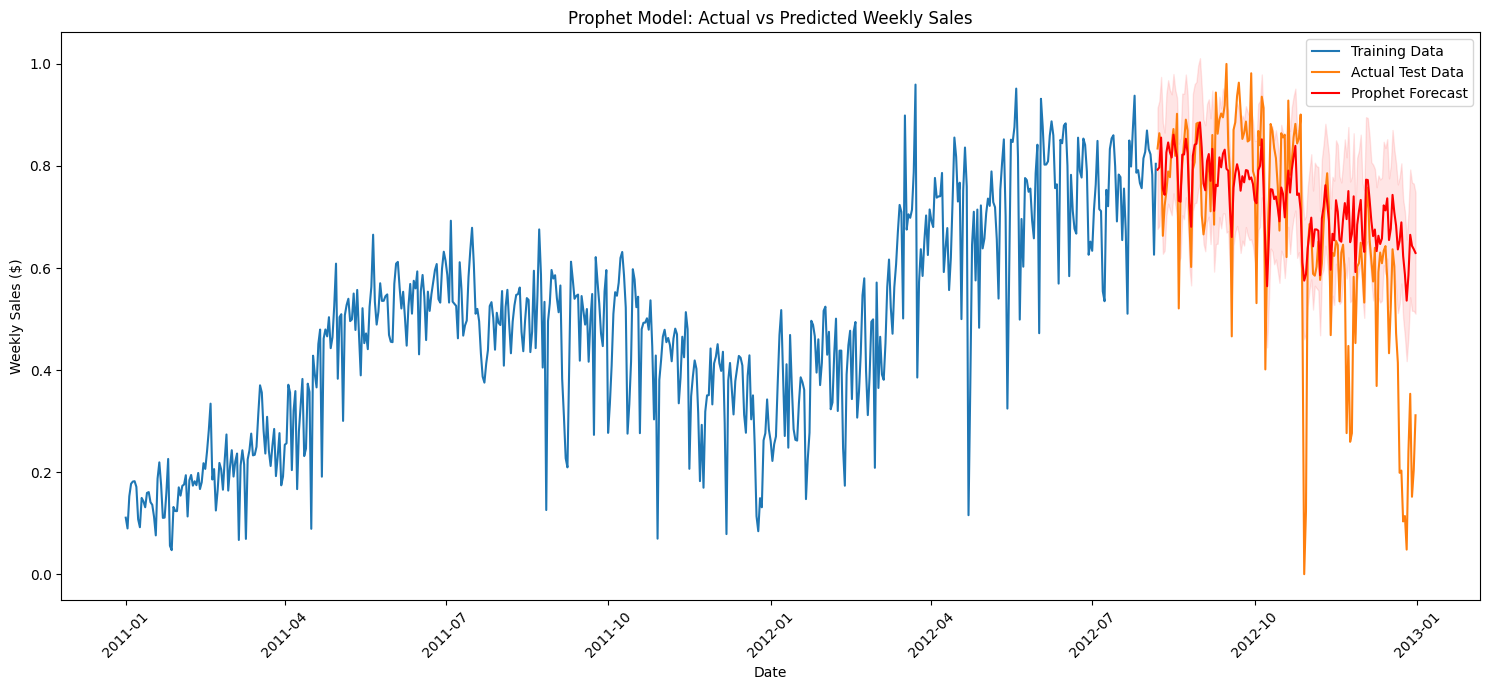

In [74]:
from sklearn.metrics import mean_absolute_error, r2_score

# Calculate metrics
mae_prophet = mean_absolute_error(prophet_test['y'], prophet_pred['yhat'])
rmse_prophet = np.sqrt(mean_squared_error(prophet_test['y'], prophet_pred['yhat']))
r2_prophet = r2_score(prophet_test['y'], prophet_pred['yhat'])

print("\
Prophet Model Metrics:")
print(f"MAE: {mae_prophet:,.2f}")
print(f"RMSE: {rmse_prophet:,.2f}")
print(f"R2 Score: {r2_prophet:.4f}")

# Plot the results
plt.figure(figsize=(15, 7))
plt.plot(prophet_train['ds'], prophet_train['y'], label='Training Data')
plt.plot(prophet_test['ds'], prophet_test['y'], label='Actual Test Data')
plt.plot(prophet_test['ds'], prophet_pred['yhat'], label='Prophet Forecast', color='red')
# plt.plot(test.index, test.sarimax, label='sarimax', color='green')
plt.fill_between(prophet_test['ds'], 
                 prophet_pred['yhat_lower'], 
                 prophet_pred['yhat_upper'], 
                 color='red', 
                 alpha=0.1)
plt.title('Prophet Model: Actual vs Predicted Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales ($)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Conclusion 

### Regression models
* Linear Regression, Ridge and SVR have less learning rate
* KNeighborsRegressor has very less learning rate, decent learning and prediction
* All tree based models are learning data well, but prediction accuracy is less (better that linear models)
* RandomForestRegressor takes highest training time
* Best prediction are given by KNeighborsRegressor and ExtraTreesRegressor. But ExtraTreesRegressor has the scope to regularise using hyperParameters
* Finding sutable hyperparameter for ExtraTreesRegressor is time consuming (5.6 sec/model)
* GPU enabled models are having good learning but prediction % is less

On default settings ExtraTreeRegressor gives the best score (70-80%) based on multiple tests.<br>
Considering ExtraTreesRegressor

### Time-series models
* ARIMA and Prophet dosent fit the data well
* SARIMAX with exogen variables learns and predicts data well with high accuracy

## Challenges 
1. Identifying the target. 3 possible target - casual, registered and total
2. exploring MultiOutput model
3. Exploring cyclic encoding of month and week data